## Preliminary Results

**Resources & References**
1. The Game: https://dinosaurgame.app/ 
2. Video Tutorial: https://www.youtube.com/watch?v=vahwuupy81A&t=5517s
3. Stable-Baselines3 Documentations: https://stable-baselines3.readthedocs.io/en/master/
4. Gymnasium Documentation: https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/
5. PyTorch DQN Documentation for Gym Retro: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


### 1. Import Dependencies

In [2]:
# Import Dependencies
import torch # PyToch library for building and training neural networks
from torch import nn
from torch.optim import Adam
import numpy as np # for numerical calculations
from collections import namedtuple, deque # provides useful data structures may not need
import random # for random sampling 
from mss import mss # for grabbing a screen shot of a monitor 
import pydirectinput # for mouse and keyboard input on windows
import cv2 # for image and video processing
import pytesseract # OCR tool for reading text from images
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from gymnasium.utils import env_checker  # Import the environment checker
from collections import deque

In [43]:
class PacMan(Env):
    def __init__(self):
        super().__init__()
        # Define spaces
        self.observation_space = Box(low=0, high=255, shape=(6,50,80), dtype=np.uint8)
        self.action_space = Discrete(5) # number of possible actions
        
        self.previous_lives = 2
        self.current_lives = self.previous_lives
        self.previous_score = 0
        
        self.pellet_address = 0x7268
        self.file_path = "pellet_count.txt"
        self.previous_pellet_count = self.read_pellet_count_from_file()
        
        # Define capture locations
        self.cap = mss()
        self.game_location = {'top':50, 'left':-2280, 'width':1400, 'height':1300} # defines game viewing location
        self.lives_location = {'top':1070, 'left':-902, 'width':600, 'height':200} # defines lives location
        self.frame_stack = deque(maxlen=6) # stack frames to provide a sense of motion
        #self.score_location = {'top':380, 'left':-920, 'width':600, 'height':80} # defines score location
        #self.done_location = {'top':508, 'left':-1810, 'width':450, 'height':80}     

        # Define templates for tracking
        self.ghost_template = cv2.imread('new_ghost_template.png', 0)
        self.pacman_life_template = cv2.imread('pacman_life_icon.png', 0)
        self.pacman_template_left = cv2.imread('pacman_template_left.png', 0)
        self.pacman_template_right = cv2.imread('pacman_template_right.png', 0)
        self.pacman_template_up = cv2.imread('pacman_template_up.png', 0)
        self.pacman_template_down = cv2.imread('pacman_template_down.png', 0)
        
    # observation of the state of the environment
    def get_observation(self):
        # Get screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Grayscale
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize
        resized = cv2.resize(gray, (80,50))
        # Add channels first
        channel = np.reshape(resized, (1,50,80))
        return channel
    
    def get_stacked_observation(self):
        # stack the frames in the deque and convert to the required shape
        return np.concatenate(list(self.frame_stack), axis=0)
    
    # get number of lives left
    def get_lives(self):   
        # Capture the area where the lives are displayed
        lives_cap = np.array(self.cap.grab(self.lives_location))[:,:,:3]
        # Convert to grayscale
        lives_gray = cv2.cvtColor(lives_cap, cv2.COLOR_BGR2GRAY)
        
        # Perform template matching
        result = cv2.matchTemplate(lives_gray, self.pacman_life_template, cv2.TM_CCORR_NORMED)
        threshold = 0.8
        locations = np.where(result >= threshold)
        
        lives_value = len(list(zip(*locations[::-1])))
        
        # Determine number of lives
        if lives_value == 684:
            num_lives = 2
        elif lives_value == 344:
            num_lives = 1
        else:
            num_lives = 0
            
        return num_lives
    
    # Get game over
    def get_done(self):
        # Get the number of lives left 
        num_lives = self.get_lives()
        return num_lives == 0 # return bool
    
    def read_pellet_count_from_file(self):
        try:
            with open(self.file_path, "r") as file:
                return int(file.read().strip())
        except (FileNotFoundError, ValueError):
            return 0
        
    # Resets the environment to its initial state
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # restart the game
        pydirectinput.click(x=-890, y=374) # select game window
        pydirectinput.press('f1') # Start state 1 save
        
        # reset pellet count
        self.previous_pellet_count = self.read_pellet_count_from_file()
        
        # reset frame stack
        self.frame_stack.clear()
        for _ in range(6):
            initial_frame = self.get_observation()
            self.frame_stack.append(initial_frame)
            
        return self.get_stacked_observation(), {}
    
    # def get_ghosts_positions(self):
    #    # Capture the area where the lives are displayed
    #     screen_capture = np.array(self.cap.grab(self.game_location))[:,:,:3]
        
    #     # Convert to grayscale
    #     gray_screen = cv2.cvtColor(screen_capture, cv2.COLOR_BGR2GRAY)
        
    #     # Load ghost template
    #     ghost_template = cv2.imread('new_ghost_template.png', 0) # Load ghost_template image in grayscale
        
    #     # Perform template matching
    #     result = cv2.matchTemplate(gray_screen, ghost_template, cv2.TM_CCOEFF_NORMED)
    #     threshold = 0.6 # typically detects all 4 ghosts
    #     locations = np.where(result >= threshold)
        
    #     # Extract positions
    #     positions = list(zip(*locations[::-1]))
    #     # Visualize the positions by drawing rectangles around matched regions
    #     # Set up the Matplotlib figure
    #     fig, ax = plt.subplots(1)
    #     ax.imshow(screen_capture)

    #     # Draw rectangles around matched locations using Matplotlib patches
    #     for loc in zip(*locations[::-1]):
    #         top_left = loc
    #         bottom_right = (top_left[0] + ghost_template.shape[1], top_left[1] + ghost_template.shape[0])
    
    #     # Create a rectangle patch and add it to the plot
    #     rect = patches.Rectangle(top_left, ghost_template.shape[1], ghost_template.shape[0], 
    #                          linewidth=2, edgecolor='g', facecolor='none')
    #     ax.add_patch(rect)
    
    def get_positions(self, template, threshold=0.4):
       # Capture the area where the lives are displayed
        screen_capture = np.array(self.cap.grab(self.game_location))[:,:,:3]
        
        # Convert to grayscale
        gray_screen = cv2.cvtColor(screen_capture, cv2.COLOR_BGR2GRAY)
        
        # Perform template matching
        result = cv2.matchTemplate(gray_screen, template, cv2.TM_CCOEFF_NORMED)
        locations = np.where(result >= threshold)
        
        # Extract positions
        positions = list(zip(*locations[::-1]))
        return positions
    
    def get_pacman_position(self):
        best_position = None
        best_score = -1
        
        templates = {
            'left': self.pacman_template_left,
            'right': self.pacman_template_right,
            'up': self.pacman_template_up,
            'down': self.pacman_template_down
        }
        
        for orientation, template in templates.items():
            positions = self.get_positions(template, threshold=0.6)
        if positions:
            result = cv2.matchTemplate(self.get_observation()[0], template, cv2.TM_CCOEFF_NORMED)
            max_val = result.max()
            
            if max_val > best_score:
                best_score = max_val
                best_position = positions[0]

        return best_position

    def get_ghost_positions(self):
        ghost_positions = self.get_positions(self.ghost_template)
        return ghost_positions
    
    def get_ghost_penalty(self, pacman_position, ghost_positions, distance_threshold=20):
        penalty = 0
        if pacman_position is None:
            return penalty
        
        for pos in ghost_positions:
            distance = np.sqrt((pacman_position[0] - pos[0])**2 + (pacman_position[1]-pos[1])**2)
            if distance < distance_threshold:
                penalty -= 50
        return penalty
    
    # Reward for eating pellets
    def get_pellet_reward(self, current_pellet_count):
        if current_pellet_count < self.previous_pellet_count:
            reward = 30 
            self.previous_pellet_count = current_pellet_count
        else:
            reward = 0    
        return reward
    
    
    # Action that is called to do something in the game
    def step(self, action):
        action_map = {
            0: 'left',   # Move Left
            1: 'right',  # Move Right
            2: 'up',     # Move Up
            3: 'down',   # Move Down
            4: 'no_op'   # No operation (do nothing)
        }
        
        if action != 4:
            pydirectinput.press(action_map[action])
            
        current_pellet_count = self.read_pellet_count_from_file()
        pellet_reward = self.get_pellet_reward(current_pellet_count)
        pacman_position = self.get_pacman_position()
        ghost_positions = self.get_ghost_positions()
        ghost_penalty = self.get_ghost_penalty(pacman_position, ghost_positions)
        
        current_lives = self.get_lives()
        life_penalty = 0
        # Penalize only when a life is lost (and only once per life loss)
        if current_lives < self.previous_lives:
            life_penalty -= 100
            self.previous_lives = current_lives # update previous lives 
            
        reward = pellet_reward + life_penalty
        
        # Penalize heavily if all lives are lost
        done = self.get_done()
        # end_game_penalty = 0
        # if done:
        #     end_game_penalty -= 500
        # else: 
        #     end_game_penalty -= 0

        # Get the next observation
        new_frame = self.get_observation()
        self.frame_stack.append(new_frame)
        stacked_observation = self.get_stacked_observation()
        
        return stacked_observation, reward, done, False, {}
    
    

In [44]:
env = PacMan()

In [45]:
ghost_positions = env.get_ghost_positions()

In [46]:
len(ghost_positions)

163

Number of Pac-Man detected: 207


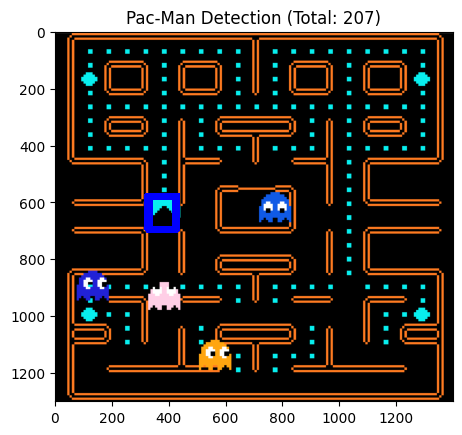

In [57]:
import matplotlib.patches as patches
cap = mss()
game_location = {'top':50, 'left':-2280, 'width':1400, 'height':1300}
screen_capture = np.array(cap.grab(game_location))[:,:,:3]
cv2.imwrite('game_capture.png', screen_capture)

ghost_template = cv2.imread('pacman_position_template.png', 0)
pacman_template_right = cv2.imread('pacman_template_right.png', 0)
pacman_template_up = cv2.imread('pacman_template_up.png', 0)
pacman_template_down = cv2.imread('pacman_template_down.png', 0)
gray_screen = cv2.cvtColor(screen_capture, cv2.COLOR_BGR2GRAY)
# Match the templates to find Pac-Man
result_left = cv2.matchTemplate(gray_screen, ghost_template, cv2.TM_CCOEFF_NORMED)
result_right = cv2.matchTemplate(gray_screen, pacman_template_right, cv2.TM_CCOEFF_NORMED)
result_up = cv2.matchTemplate(gray_screen, pacman_template_up, cv2.TM_CCOEFF_NORMED)
result_down = cv2.matchTemplate(gray_screen, pacman_template_down, cv2.TM_CCOEFF_NORMED)
threshold = 0.5 # Adjust this value based on testing
locations_left = np.where(result_left >= threshold)
locations_right = np.where(result_right >= threshold)
locations_up = np.where(result_up >= threshold)
locations_down = np.where(result_down >= threshold)
combined_locations = list(zip(*locations_left[::-1])) + list(zip(*locations_right[::-1])) + list(zip(*locations_up[::-1])) + list(zip(*locations_down[::-1]))

# Count the number of Pac-Man matches found
num_pacman = len(combined_locations)
print(f"Number of Pac-Man detected: {num_pacman}")

# Set up the Matplotlib figure
fig, ax = plt.subplots(1)
ax.imshow(screen_capture)

# Draw rectangles around matched locations using Matplotlib patches
for loc in combined_locations:
    top_left = loc
    bottom_right = (top_left[0] + pacman_template_right.shape[1], top_left[1] + pacman_template_right.shape[0])
    
    # Create a rectangle patch and add it to the plot
    rect = patches.Rectangle(top_left, pacman_template_right.shape[1], pacman_template_right.shape[0], 
                             linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

# Display the result
plt.title(f'Pac-Man Detection (Total: {num_pacman})')
plt.show()


In [15]:
for loc in zip(*locations[::-1]):
    # Top-left corner of the matched region
    top_left = loc
    # Bottom-right corner based on template size
    bottom_right = (top_left[0] + ghost_template.shape[1], top_left[1] + ghost_template.shape[0])
    # Draw the rectangle on the captured screen
    cv2.rectangle(screen_capture, top_left, bottom_right, (0, 255, 0), 2)


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [16]:
cv2.imshow('Ghost Detection', screen_capture)
cv2.waitKey(0)  # Wait for a key press to close the window


-1

In [48]:
env = PacMan()

In [56]:
env.get_ghosts_positions()

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


In [ ]:

start_time = time.time()

# Designing convolutional neural network
class GameNet(nn.Module): # defines a new neural netwokr model that inherits from Pytorch's base class nn.module
    def __init__(self, input_channels, num_actions): 
        super(GameNet, self).__init__() # calls the initializer of the parent class nn.module 
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4) # convolutional layer with 32 filters, each of size 8 x8, applied with a stride of 4
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # convolutional layer with 64 filters, each of size 4 x 4, applied with a stride of 2
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # convolutional layer with 64 filters, each of size 3 x 3
        
        self._calculate_fc_input_size(input_channels)
        
        self.fc1 = nn.Linear(self.fc_input_size, 512) # fully connected layer with 512 units
        self.fc2 = nn.Linear(512, num_actions) # final fully connected layer with output units equal to the number of possible actions
        
    def _calculate_fc_input_size(self, input_channels):
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 50, 80)
            x = torch.relu(self.conv1(dummy_input))
            x = torch.relu(self.conv2(x))
            x = torch.relu(self.conv3(x))
            self.fc_input_size = x.view(1, -1).size(1)  # Flatten and get the size
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1) # Flatten the output from conv layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Define a replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [ ]:
# Hyperparameters
num_episodes = 100
batch_size = 32
gamma = 0.99
epsilon = 0.1 # Exploration rate
buffer_capacity = 10000
learning_rate = 1e-3    

# Initialize environment and model
env = PacMan()
input_channels = env.observation_space.shape[0]
num_actions = env.action_space.n

model = GameNet(input_channels, num_actions)
target_model = GameNet(input_channels, num_actions)
target_model.load_state_dict(model.state_dict())
optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
replay_buffer = ReplayBuffer(buffer_capacity) # Stores experiences (state, action, reward, next state, done) for training

# Training function to choose an action using epsilon-greedy policy (Exploration vs exploitation)
def select_action(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample() # Random action (Exploration)
    else:
        state = torch.FloatTensor(state).unsqueeze(0) # Add batch dimension
        with torch.no_grad():
            q_values = model(state)
        return q_values.argmax().item() # Action with highest Q-value

In [ ]:
# Training function to procvide interaction with the environment, 
def train_gamenet(env, model, target_model, optimizer, criterion, replay_buffer, num_episodes=10):
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            action = select_action(state, epsilon)
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            
            # Store experience in replay buffer
            replay_buffer.push((state, action, reward, next_state, done))
            state = next_state
            
            # Perform optimization step
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                states = torch.FloatTensor(np.array(states))
                actions = torch.LongTensor(np.array(actions))
                rewards = torch.FloatTensor(np.array(rewards))
                next_states = torch.FloatTensor(np.array(next_states))
                dones = torch.FloatTensor(np.array(dones))
                
                # Compute Q-values
                q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                next_q_values = target_model(next_states).max(1)[0]
                target_q_values = rewards + (gamma * next_q_values * (1 - dones))
                
                # Compute loss
                loss = criterion(q_values, target_q_values)
                
                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        # Print progress
        print(f"Episode {episode}: Total Reward = {total_reward}")
        
        # Update target network
        if episode % 100 == 0:
            target_model.load_state_dict(model.state_dict())
        
train_gamenet(env, model, target_model, optimizer, criterion, replay_buffer, num_episodes)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total training time: {elapsed_time // 60:.0f} minutes, {elapsed_time % 60:.0f} seconds")

## Test Environment

In [821]:
env = PacMan()

In [ ]:
current_pellet_count, obs, reward, done, truncated, info = env.step(env.action_space.sample())
print(current_pellet_count)
print(reward)

In [ ]:
pellet_count = env.read_pellet_count_from_file()
pellet_count

In [ ]:
current_pellet_count

In [547]:
channel = env.get_observation()

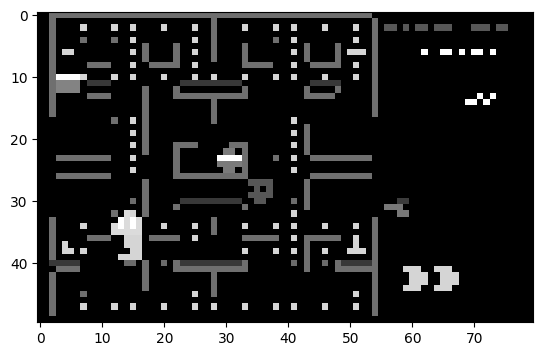

In [32]:
plt.imshow(cv2.cvtColor(env.get_observation()[0], cv2.COLOR_BGR2RGB))

In [ ]:
env = PacMan()
score_cap, score_text = env.get_score()
plt.imshow(score_cap)

In [ ]:
score_text

In [ ]:
env.reset()

In [ ]:
lives_cap, num_lives = env.get_lives()
num_lives

In [ ]:
plt.imshow(lives_cap)

In [ ]:
done = env.get_done()
done


In [441]:
env.render()

In [448]:
env.close()

In [ ]:
# Game loop
obs = env.reset()
done = False

while not done:
    #env.render()  # Render the game screen
    action = env.action_space.sample()  # Sample random action
    obs, reward, done, truncated, info = env.step(action)  # Take the step
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Graceful exit if 'q' is pressed
        done = True

In [ ]:
# Play 10 games
for episode in range(2):
    obs = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        obs, reward, done, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')

## Training

In [822]:
# import dependencies
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [824]:
# Check environment for errors
env_checker.check_env(env)

In [823]:
class TrainAndLoggingCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
            
        return True

In [825]:
# Declare directories to store files
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs'

In [826]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [827]:
from stable_baselines3 import DQN

In [ ]:
# declare model
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=1200000, learning_starts=1000, exploration_initial_eps=1.0, exploration_final_eps=0.1, exploration_fraction=0.1, learning_rate = 0.01 )

In [ ]:
# start learning
model.learn(total_timesteps=5000, callback=callback)

In [ ]:
# load model
model.load(os.path.join('train', 'best_model_5000'))


In [ ]:
# play loaded model
for episode in range(10):
    obs, _ = env.reset()
    done =False
    total_reward = 0
    
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(int(action))
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')
    time.sleep(2)